# Prepare & Leverage Image Data for DataRobot with Databricks

**Author**: Andrew Mathis

**Version date**: 2023-02-16

## Overview

In this notebook, you will import image files using Spark and prepare them into a data frame suitable for ingest into DataRobot.

While there are other methods of ingesting image data into DataRobot (e.g., using a ZIP archive of image files as described in [the Visual AI documentation](https://docs.datarobot.com/en/docs/modeling/special-workflows/visual-ai/vai-model.html#prepare-the-dataset)), in this notebook you will encode the image data directly into the data frame using base64 encoding. This methodology allows you to keep all of the relevant data in a single data frame, and works well for a Databricks environment.

In this notebook, you will learn how to:

1. Set up libraries and connect to DataRobot
2. Use Spark to read images from a data source as binary data
3. Transform binary image data for ingest into DataRobot
4. Ingest the prepared dataframe into DataRobot's AI Catalog
5. Create and start a multiclass classification project in DataRobot

## Setup

Prior to execution, you will need to set up a few dependencies:

1. Install the Python package **datarobot** (Python library used to communicate with the DataRobot platform) into your Databricks cluster, provided via PyPI; this notebook is designed for versions 2.28.x and above.
1. Load the image dataset into your Spark-accessible data store of choice (DBFS, S3, etc.). This example, uses a Plant Disease dataset, [available for download](https://s3.amazonaws.com/datarobot-use-case-datasets/DR_Demo_Plant_Disease_train.zip). Load the contents of the ZIP archive into your data store, and store the path to the top-level `PlantDisease_train` directory in the `IMAGE_DIRECTORY` variable below.

### Licensing
The Plant Disease dataset used here is a subset of the [Plant Disease dataset](https://www.kaggle.com/emmarex/plantdisease), uploaded to Kaggle by [Tairu Oluwafemi Emmanuel](https://www.kaggle.com/emmarex). That data was originally sourced from [Plant Village](https://web.archive.org/web/20201102090501/https://plantvillage.psu.edu/about), whose contents (at the time of archiving) were licensed under [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/).

### Install and import libraries

First,import the necessary libraries. You'll be using Pandas and Pyspark for data manipulations, as well as using the DataRobot Python SDK. You'll also use some standard Python libraries, most notably the `base64` library for performing base64 encoding.

In [0]:
pip install datarobot 

Python interpreter will be restarted.
Requirement already satisfied: datarobot in /databricks/python3/lib/python3.8/site-packages (3.1.0)
Requirement already satisfied: pandas>=0.15 in /databricks/python3/lib/python3.8/site-packages (from datarobot) (1.2.4)
Requirement already satisfied: pyyaml>=3.11 in /databricks/python3/lib/python3.8/site-packages (from datarobot) (6.0)
Requirement already satisfied: typing-extensions==4.3.0 in /databricks/python3/lib/python3.8/site-packages (from datarobot) (4.3.0)
Requirement already satisfied: requests>=2.21 in /databricks/python3/lib/python3.8/site-packages (from datarobot) (2.25.1)
Requirement already satisfied: urllib3>=1.23 in /databricks/python3/lib/python3.8/site-packages (from datarobot) (1.25.11)
Requirement already satisfied: trafaret!=1.1.0,<2.2,>=0.7 in /databricks/python3/lib/python3.8/site-packages (from datarobot) (2.1.1)
Requirement already satisfied: requests-toolbelt>=0.6 in /databricks/python3/lib/python3.8/site-packages (from datarobot) (0.10.1)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from datarobot) (1.20.1)
Requirement already satisfied: contextlib2>=0.5.5 in /databricks/python3/lib/python3.8/site-packages (from datarobot) (21.6.0)
Requirement already satisfied: pytz>=2017.3 in /databricks/python3/lib/python3.8/site-packages (from pandas>=0.15->datarobot) (2020.5)
Requirement already satisfied: python-dateutil>=2.7.3 in /databricks/python3/lib/python3.8/site-packages (from pandas>=0.15->datarobot) (2.8.1)
Requirement already satisfied: six>=1.5 in /databricks/python3/lib/python3.8/site-packages (from python-dateutil>=2.7.3->pandas>=0.15->datarobot) (1.15.0)
Requirement already satisfied: certifi>=2017.4.17 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.21->datarobot) (2020.12.5)
Requirement already satisfied: chardet<5,>=3.0.2 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.21->datarobot) (4.0.0)
Requirement already satisfied: idna<3,>=2.5 in /databricks/python3/lib/python3.8/site-packages (from requests>=2.21->datarobot) (2.10)
Python interpreter will be restarted.

In [0]:
import base64
from pathlib import Path
from typing import Iterable

import datarobot as dr
import pandas as pd
import pyspark
from pyspark.sql.functions import col, regexp_extract, udf
from pyspark.sql.types import StringType

### Connect to DataRobot

To connect to DataRobot, you need to provide your API token and the endpoint. Your API token can be found in the DataRobot UI in the **Developer tools** section, accessed from the profile menu in the top right corner. Copy the API token and paste in the cell below. 

For more information, please refer to the following documentation:

- [Create and manage API keys via developer tools in the GUI](https://docs.datarobot.com/en/docs/platform/account-mgmt/acct-settings/api-key-mgmt.html#api-key-management)
- [Different options to connect to DataRobot from the API client](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html)

In [0]:
ENDPOINT = "https://app.datarobot.com/api/v2"
API_TOKEN = "API"

dr.Client(token=API_TOKEN, endpoint=ENDPOINT, user_agent_suffix="AIA-AE-VAI-82")

Out[2]: <datarobot.rest.RESTClientObject at 0x7f08c0063af0>

## Read images as binary data

In this step, you'll use `spark.read.format("binaryFile")` to recursively load the images within your top-level image directory. This will result in a Spark dataframe that captures each image's path, modification time, size, and binary contents.

In [0]:
# Replace this with the path to your uploaded PlantDisease_train folder in your data source
IMAGE_DIRECTORY = "/FileStore/amathis/PlantDisease_train"

In [0]:
# List the directory to make sure the sub-folders are present
dbutils.fs.ls(IMAGE_DIRECTORY)

Out[4]: [FileInfo(path='dbfs:/FileStore/amathis/PlantDisease_train/Bell pepper/', name='Bell pepper/', size=0, modificationTime=1676566246000),
 FileInfo(path='dbfs:/FileStore/amathis/PlantDisease_train/Bell pepper bacterial spot/', name='Bell pepper bacterial spot/', size=0, modificationTime=1676566381000),
 FileInfo(path='dbfs:/FileStore/amathis/PlantDisease_train/Potato/', name='Potato/', size=0, modificationTime=1676566270000),
 FileInfo(path='dbfs:/FileStore/amathis/PlantDisease_train/Potato early blight/', name='Potato early blight/', size=0, modificationTime=1676566393000),
 FileInfo(path='dbfs:/FileStore/amathis/PlantDisease_train/Potato late blight/', name='Potato late blight/', size=0, modificationTime=1676566357000),
 FileInfo(path='dbfs:/FileStore/amathis/PlantDisease_train/Tomato/', name='Tomato/', size=0, modificationTime=1676566404000),
 FileInfo(path='dbfs:/FileStore/amathis/PlantDisease_train/Tomato bacterial spot/', name='Tomato bacterial spot/', size=0, modificationTime=1676566345000),
 FileInfo(path='dbfs:/FileStore/amathis/PlantDisease_train/Tomato early blight/', name='Tomato early blight/', size=0, modificationTime=1676566297000),
 FileInfo(path='dbfs:/FileStore/amathis/PlantDisease_train/Tomato late blight/', name='Tomato late blight/', size=0, modificationTime=1676566235000),
 FileInfo(path='dbfs:/FileStore/amathis/PlantDisease_train/Tomato leaf mold/', name='Tomato leaf mold/', size=0, modificationTime=1676566308000),
 FileInfo(path='dbfs:/FileStore/amathis/PlantDisease_train/Tomato leaf spot/', name='Tomato leaf spot/', size=0, modificationTime=1676566369000),
 FileInfo(path='dbfs:/FileStore/amathis/PlantDisease_train/Tomato mosaic virus/', name='Tomato mosaic virus/', size=0, modificationTime=1676566258000),
 FileInfo(path='dbfs:/FileStore/amathis/PlantDisease_train/Tomato spider mites/', name='Tomato spider mites/', size=0, modificationTime=1676566284000),
 FileInfo(path='dbfs:/FileStore/amathis/PlantDisease_train/Tomato target spot/', name='Tomato target spot/', size=0, modificationTime=1676566334000),
 FileInfo(path='dbfs:/FileStore/amathis/PlantDisease_train/Tomato yellow leaf curl virus/', name='Tomato yellow leaf curl virus/', size=0, modificationTime=1676566321000)]

In [0]:
# Now read
images = (
    spark.read.format("binaryFile")
    # .option("pathGlobFilter", "*.JPG") # Warning: if you use a filter, be aware that the match is case sensitive
    .option("recursiveFileLookup", "true").load(IMAGE_DIRECTORY)
)
display(images.limit(5))

path modificationTime length content dbfs:/FileStore/amathis/PlantDisease_train/Tomato/1d1221b5_1a59_43bb_a616_8f7a404785b6___RS_HL_0451.JPG 2023-02-16T16:53:17.000+0000 28319 List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABkCAIAAAD/gAIDAABei0lEQVR42jy7VXMk2bosqOc7Z1NxdVc1dzFJJWaGlJSkZGZmZmZmVKa4pOKG02fvfcAGHu7DtXmY+UfjWTl2zJYti4wMZcbycPfPv8jQSLvSPqwfdqqdWr52dXJVzpTbxXrE6S/GMrV08ajWOa53w25/KhLrletvmodpX7iSydeLlVa+itEtNXBYNpRoF2v1QqWcLZ73T39596nX7GKUMoXPbz++Pbv85+9/P2x0Pl19+NePv+PrTrunlWzlqHV00b+4PL7ERqPYKKaK2H/SOTlsHF4cnR61cdhJv3nUqfT6jdN8ppxJFdqNw2q+1sg1yvHyZefqqHJcT9e7lW4xXTrqHB0dntTzzZP2eavUTYdzR83TfuPkovfu/PBtq9SrZlupUP5N/33YHU1HMrV8PRvLVXO1Zqll1dsT4VQ2kU9G0sfd017rCB9YyVbfn3+I+eOtcluvMLjM7pF4IJ5P5AFWvVDPRDPNUrOZr2aCcaw/6goAi7f9806lUc0Vqqncr2dXtVSuni/VC2Xg2MxVcuFkJZnHYceNbiVTzMRStUIFuFTz5XgwGvYGAdBJ96hVabSrzd8+/PLb+1+BDhA5751/uvz05uhNt9YFfEPIsP+4fRzzx447PYwqziSaLaUqjWLn9OhdPJIrZKrn/Te1XK1dbv1y/vFN9yIbSp92TtrVTjQQOz48fXN0ddTEh5z1m8e9+lG32iulavV8J+pNxv3pVCjXq5/k4oV8olDOVABZxBt1Wzz4FofJFfZG8OGXJ1eFVMlr9xVTpWQo1a50urXDIWQjHy4+fL76jOuMgZNOA9rGIcACBPVMKWjzlOJZj8n2/vTiw8nFYbkOftUyhXap1inW24XaefuoX203suUq+BVLJUKxTq2VjiYruRJY9u78CgABJiB41O5h7tTawKWQLFRz1V/e/gJ0gFc2ln17+hbUxlvvz9/3m/1KtnzcPnp//g4X75+//ns5Uz3pvasWe+fH7056Z81K7fwYF6BSTGUu+sfg8vnRxa8ffjts9uOBxHnvotfsg5JvT9/VC418vHRYG9DztHNxefSumKxc9N+ATcDrtHvWa/RBLhuYFUxatFZsn3ROc/E8DgDvgFfUFzOqTNgzAAtXGJcU5IIGsQCM9yeXgADEibmDIFfSF6mlC0e1VqdUO2q0352cR5zeiNNXTuQK0TRgTfmjQO23y49tEDBfvjg6A1i5RAb8en/xtlGqDQfeAr9OusegML4UXMbl+e39b8PvxYxLlQwlgRTexRljqdiGMHH9WuVWMVOJhpPxaCKViGcz8ZPTzulpu9upfP5wWSnkO/XOf/zxn+DFr+8GzMVHldIlcBbSToUznWq3Ve7kYvl2GV9aw7ILySLAKqXLYE2j2KxkKmalKR1MpUPpSqqMjUq6DKQO6z2dXA/UwC+wbARnA6TODs9whTHj/A4rbUivV2kBiHQgBmPKBjGX0+FovVQ57faueif5UBwCBOmGA7C+OTx5f34FWsGn+q1DoAP14Zrnk9luvY39IFq30a4Xa4lgAg41hGaowV6jB0Jhnfh27AE0jUL7tHOeCqeBY7Nc/8dvf7RqldOjTrtV/v2P9//+X792jkqdo0L7MPv//L//88O7N798+FzOVrPR/Jvjc1yk407/94+/4kuPOwNpAzisHCQCfSA9iA4AgYBDwwJ36rm6y+D0GN1Jf6KaKie8sWwEHlkBT3EMsIYMMUZweXHpcJaADCeKlyfNPtwdGIE7cHrgVYgkT7Dgaj0Zifqdbq/J2sqWINKTxiFgTXjDOL6UyJXTBRCqmM6DRDhjwFQvVrPxNNQHj8cCINKjVh+XZPhdfocfeEFo9Xwd1+xN/+KwdgiKAbWL3lsIp13pwiWqhVK9WEol3Im43e5UlOvRejdt9ajMbmmm7L24ah8ftyuF8kXv8vzwsllu4BxwtfB1OAe8RA2BCeJbUmEYUBvAQVOADOPz1S+ADBRr5hshezAfzrZyDYvC5NI5ABnYBJiALCDGDEWPdEqNy95ZPprulptxb6SaKmLlqIAAAh6PSgc/Al7pQBQW3ik3qpki0IGjQ32YMSDGj6dXrUK1ki0lw3GcIgwrFogMnR5Euzy5AHzwL9CtlC7iUke8EcCEU0dJKaeKZ62jVq4Gt+6Wux/PPqGEnXfe5SKFdyeX3VqllAkfd/OJpF0ooSpUfE/I5giYyNxthmjX6lW+++Xof/3f/0e7Ue/WDyOeOGw+G89hwMViwXi92AChQGSUNqwWogME4MiwFOIt7MFbjUKzUWi4TK6EP5EJZ9LhdMwXg/GBXFAfWAmOQ7kjsOfLw1NA8/n8HawK0gNlAAdmGBbIBTiwE6idtfq/XLzHMXgL82G5CY/PR1J4d+Bu7kC32jqstwcqaPeG0EBB8HXMuM5wesBXK1Rh50Mvh9wGVThXPSw2u4Vmu9AoxPKFRLGQKF31Lxv5SjYaaZXT6ag94FEWy0EKfYvJpXLFbH/czVXQtyiLaotQaxEVy7HT416jhKvUT8eySADtWrdaqBcz5YvjS9S7kDsMBr07ew90YEMACEhh/YAPqAGLRqmJZHB2eA4GARQMwARaDQ0ex3usXqfJNfKme/L71SeAgpUDOEADRwccV70zjVAOloFfv775AAsDInFPCF4OcMEm5AZADMPCTrAPLwtxVONCNpIE+46ah71a++Obd8Du1/efYV5QB8riu7O3kGFpkGIqUCJGv96LucKtfB3yB9xAuZjJBTy2ailp0IrVCi6fs++0KzqHeaNF7vZbNGbFxv7y7MbE4vbkPmNtY2/WYlP9+vkDPraaa4a8EYBVzlVL2Uqz0v549RlUOm4jTKDsXoImgCDsiQCOq5O3AAtmD5uv5KpDjAAlQIROMQNHcBDwIVv4HQGvzTeCRQIXEOfd0QXiwmmzBwZhxjaQ8ltcIbu3mioAFMCKDcAK+Ib8wsBhEGnnS46Foo/qnUaughjRLTcSvgjqI5gFo4UMwawvgQvOeg6LBLNg3hBIKYXPqbWLzWq2UMpmmrXi1UW/18+p1azFxZcsFoFKWVer+b6AJZ0LiWTMzf2lJ2M/re4vTa+Ore3NLG9N2JyaajmP8FEvoIA0gVEqmokG4rViIxPPwZtg5wACuIBf8GxgEXSFAASoBNaAPsALh4FE8C+8hT1AClaFGcNucIBWg1AKaGDSIBQ2AAc2AN9vV5+gLyACJeIlGAcqAVPkiWGyB7LgFw7ANvDCwcAL9XFwDJqBL9Ef714encPaUaFg9tj44/PvJ53j/w6lgAwlGKfeq/YRMuvFYr9T6x2Wzy/qwaghmXUyubsbO3NjE084fKrZphXL2FIV+8GLb4jMLQIdnkU+4O3Mr40q1Lz/63//T5hgq3wIgPKpIoI49NhvH9dLTZ/djwWDKUhewAtMASJ4CZZhBuNAPRwAsAAouOYwOrENTA1KIxJMwBmEioEsUtjIRecYTvT++A0WD1CwchAHSwWDoDhwB/vxEsYEOAAlyIUB3QERyHD4Ekfir2LOQD1VzAbi7VwV20eVdi1bQm5Affyvv/8HlIjYdXF0DsOCtSPcgVkogsVkKRWCUxQKmXQxH0tn3Menh

## Transform data for ingest to DataRobot

Now you will transform the binary data frame into a format suitable for ingest to DataRobot. You'll encode the binary content of the image files as base64 strings, and extract the target class name from the folder structure of the path.

### Prepare functions

First we will prepare the functions to perform the Spark dataframe manipulations for base64 encoding and path manipulation.

In [0]:
@udf(StringType())
def b64_udf(content: bytes) -> str:
    return base64.b64encode(content).decode("ascii")

In [0]:
@udf(StringType())
def extract_basename_udf(path_str: str) -> str:
    return Path(path_str).name

In [0]:
def prepare_images_transform(
    df: pyspark.sql.dataframe.DataFrame,
) -> pyspark.sql.dataframe.DataFrame:
    """
    An example transform on the outputs of a binaryFile format Spark read, which base64 encodes the file contents and extracts helpful information.
    """
    return (
        df
        # .filter(df.path.endswith('.JPG')) # example filtering
        .select(
            regexp_extract("path", r"PlantDisease_train\/([\w\s]+)\/", 1).alias(
                "target"
            ),  # Extract the class based on some pattern of the path name
            extract_basename_udf(col("path")).alias(
                "basename"
            ),  # Extract the basename of the image, to help with e.g. future joins
            b64_udf(col("content")).alias(
                "b64image"
            ),  # Base64 encode the binary content
            col("content"),
        )
    )

### Perform the transform

Now apply the transform function to actually transform the binary data frame into your data frame for DataRobot, and bring it into memory as a Pandas data frame. Note that you will retain the binary content as well temporarily, just for preview purposes. This would also be a great opportunity to join in additional data alongside the image data, by e.g. performing joins based on the `basename` column.

In [0]:
encoded_df = images.transform(prepare_images_transform)
display(encoded_df)

target basename b64image content Tomato 1d1221b5_1a59_43bb_a616_8f7a404785b6___RS_HL_0451.JPG /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDWaGaCMiU2yyE7FZCVOScDgNwm3P59qhMzPHEy3GyKEmJXRlJUkZUljwRknv25708zJc3MytJtWTc2DuIRiWwzNnOR1564/FZjMk115q2qKTNtJK+WVCggEnIHI25I4wBgDgmizOlULO88IjCrGgJj2FYy3JxjGcYzjpkn15k8yEwS211KXPleW7Ig/enGcbt3JICk9OgznNWbiZru3lUKhJCqwC7YmOW2kEHAHzE5w2PXBBrM3oBK8ZmZlxtyThcbgR8vqOc4GRnnrlDNK3hkkRLmON3t2CPJGm0HzBkAMoAIJGD94g+5FRsiJcBpJTGZ5cRlsMTlhjaQPmXC5K+ud3TkcSSRps2YVskQkPuBIGMYwfYDtnoeaiurmzvlMUiTK/lv5crIcZ+Ynkheny9eePXBVB5Fgqzy/IUMmVY71UKCeBgHgj5T1yCQd3Q5jQRBi+UnnjXLskhD98IRkEjajdicKe3VkVsLgCMzwhl3M/ykYbKnaBkYAySN2TxnrzTrK4uLad7lEmFqj77hhLgL1YkkAeucEc85xjBYC20lwJjxKzskZSCQkqCBuOwhjwcZwAT+pqR557uWPyFadW/dlmjKYXoQy4BxnGcgc9ugLZblI5P3K+UwQnZKytnqVwOOn94Z4H1NKqRwgy2/nkbFkAU52ZcksNpGBwAM88jg5NAi4Bd2tjbRmNxceTlfLUEEA5yV528jHI6+hLEC30e+SSXbI7yAIqTl3VvmwwGSF+UgHnHAJziqyMr6pG6qSAAFf5Su85yOBxlQQPvcEg4BNNX/AEOSAb1mhkQRx3DI3BIHAUHBIJzhhznOB8oABPeymMSP++jSUblkR/lPKgtjcQP48jjO1mBPazIqW0m2GUhcYRpX3EDGcbOMjjrgj7oOaoxSNBdr5rRFZMDcZNwUHIxjAYH5uoOOmehqCyvJbWJ4mLwoxOUIUbMc7gOpP3scY+de5pgWCiPalpIHypxljtMiDA2hvule+7IB4GBgAy3HmvbtJCiNcRgyDMh3HPBYfKAMcAgdQT14JW2aJvlZREXZnZAwzIpYKoC7jk/JnIxweMcUkFoWUyWsafZ1dmiJA8skjopbHBGM/L2/AgCxmSR43jg8ySBgokkBjLqRtZGwBlQGYjkHqPQGBVdYVluBa+VNIURWyeMnb1JwWOFOTnofYOlMskUMAkUtDmMOTuQbl+YEHIGACPT5unqrCOG7uvtEWXkB5hJGDuwCB3yATwPXrnFGwELW7Kl+ixgBZwjRPkyHggvknkllC4AwTwTgEVYls3N3JAYpflkRjEQo4J+YhQCAAcY54A5wQAc4S2CSQoftM0hIEihX3RnaVKFlOSwUHAwM4I+l17zSdOkhIiSQtkyPKA5dflwWb5mJ27icA9McbgBDqLoTew4xzX90GS3mVGHmEuqsZCRu4bJy2c+nJ69cPSC7MjTKZAjjMyyPywwQGGeSSTz97nOcg8yaS9td6fMs9o0Ek0W5Ejj2CPkYwVAUgsxwQPc9QBF5kkNr5VjiBFJk8udljV5MBl+Vex2c89zkjHDjLmHe423Hmhvsyzso2ncqCJgW28k7iu3OTu4Hzc8ikVEgtd4QJEwVRPlsFm2H5yB0GF5Iz0zjg083ay3TqoWaOREiDEjajjac/KM55GDyc4IPFRusCbWwUJjV9hlAPCtuYksWOMjP0ORzxVxjGlnuI4HUQmRnyHc8jcw+bdnnoxAOeQx57pFG9vDIz2Vs32lYwjozHaMjsc9uTtIUAggZApJPLtLsQMyRxschZ0IjHy4c5HGSPvHqBjkcYhIdoUeEsImG7a7bSd20A/TqeCx5YcEmncANv9nDR/aSyMPlXOM/N8nJOAwBADHlSOACOEuo763jIlzImQrr5oVhlWHHr39jx/tZmhUSyxsYJtki5DJEpiLv8uWTGCSF6YHKjA4xSXgEUaeVNE8aKqq6YIdEc7SRtyAM85I6HvQBnWssatDDMrvZOflQMTtU4XdgcAZbkj0wc8ita7kw7RRSI0vkgyIWPyhQ2MnCll55UjIJHcCswxSrfzxBEhhe63FRfKAXIwGz03AAN/dzyOcArFMzzJDIJYmjDJK2OAQdwG0Z6gEZGMduoyBYnEy/YhFNcxNEBiRlI3EgcsG/gGUPHXJ6biDUSx2uqXD3eCqpHk7ogACQcEjqygAjByenT7tT3Cma2/fs5t2wZiHAKs4UDtkhSMck449SA11lYeVGhmW1UkNMwAEkSgEKG529fUZA4BckgGnJGPs8fmNM8XnqkTInzAYJB5bKnB9RyAMADIqTwxyOZYIAsqgkgKCWG0A8Z4zn05B/A3RYDyEKxIqyFZF83HChd2Nx4wAMewGSABmq9zMscp3pGzSMCD5YGV+fA25HJ9scE+1SMqsz+TdyKxMcUbsYm+RyOpDdP7w55qO0uEugkNxIA5+YuSAIgCpwVYcAk5HGfmzk4FWLiZbnT4zPkyJKceVIVym8HAGMjnrz/EAOSDSNbW0txK0zSSRySDy0lwWYYHZuACNnUHJNAA0X2RGhktpLjJCt5SEHCAKoAyuD8wPGMAk4AFTSeXPObvdLkuWdRklsYGFw3HQ5zk4b2zUOCbe5jCZaWZdrNGVR23ZCsrfLt56euCOcAuzFFqCvGm0eayKJm2ybd2BGp55yME9yxGQMkgDTLG0UzxyK0kwIZpfmYMfu9cHjKgcYUDI61WjnkNk0xuFgSUDLZXAO7CkP1BOctx2zjmr7SK8M4iSRJEi3hW7Js6uRxnBDdCRnj5eKruptdsc4kzGxiZV2t5ZHOR6tgc5HVRycigBwnigZBiWMHzI3k4ZgefQjgjg9845weZAlpcBJVjUvlRnaq5Xn5vmJw4wp4YbgP4T1hiv9tpskVWRHWLBKIzgYGPlwpG4KeTgKPSnZWWOeO6jUwZVvOV/LIJ5OBkBcdQAOmOMc0BYuJH5krbbnErIFdwR82cnhj3yMdMnnHuyQwkIjiS3hRJIxI/7xShJGVKjgZY8453ZyTzT2Z7zdb/Z02vnzdjqXVg2CWzwcdSDzg44GcSo0DWc8YmjmijcoJRxjLYz5Z5UnnB74wO

### Convert to Pandas

For upload to DataRobot, convert your Spark data frame into a Pandas dataframe.

**Note** that this will bring the data into Driver memory, so be sure you have a small enough dataset to fit into memory. When working with data that exceeds your memory size, you might downsample the Spark data first before converting to a Pandas data frame.

In [0]:
encoded_df_pandas = encoded_df.drop(
    "content"
).toPandas()  # You don't need the binary content anymore, as you will be using the base64-encoded data
encoded_df_pandas

Out[10]:

target 
 basename 
 b64image 
 
 
 
 
 0 
 Tomato 
 1d1221b5_1a59_43bb_a616_8f7a404785b6___RS_HL_0... 
 /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw... 
 
 
 1 
 Tomato 
 2e0a7517_332f_4799_a083_5d393172909a___RS_HL_0... 
 /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw... 
 
 
 2 
 Tomato 
 6e583c78_1f36_4d5e_bc0e_24f3c76a2c1d___RS_HL_0... 
 /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw... 
 
 
 3 
 Tomato 
 5733d6bf_494a_4da8_a15f_5903f4f05807___RS_HL_0... 
 /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw... 
 
 
 4 
 Tomato 
 8ac1645d_48d9_4f3e_842b_0187daeeb57c___RS_HL_0... 
 /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw... 
 
 
 ... 
 ... 
 ... 
 ... 
 
 
 1495 
 Tomato late blight 
 4cdd9b83_3ec9_40af_b402_a96827e69b84___GHLB2_L... 
 /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw... 
 
 
 1496 
 Tomato yellow leaf curl virus 
 506efa52_b002_49a5_aa72_022e24185161___UF_GRC_... 
 /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw... 
 
 
 1497 
 Tomato late blight 
 7f533ee8_1d72_486e_b2a6_b5ef2ac7cc88___GHLB2_L... 
 /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw... 
 
 
 1498 
 Tomato yellow leaf curl virus 
 29e2d4fc_01ad_4da0_8b2c_dfd51fcc294c___UF_GRC_... 
 /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw... 
 
 
 1499 
 Tomato yellow leaf curl virus 
 5a0a1e8e_5d20_462f_95e2_69756e4f21c3___UF_GRC_... 
 /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw... 
 
 
 
 1500 rows × 3 columns

Out[11]:

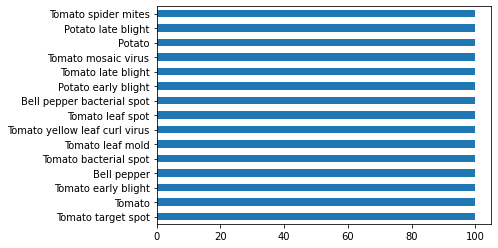

<AxesSubplot:>

In [0]:
encoded_df_pandas["target"].value_counts(dropna=False).plot(kind="barh")

## Modeling

### Ingest data

Now that you have your prepared dataframe, upload it to the DataRobot AI Catalog to make it available for project creation.

In [0]:
# Create the dataset in the AI Catalog
dataset = dr.Dataset.create_from_in_memory_data(
    encoded_df_pandas
)  # we recommend increasin the read_timeout parameter in case you experience a timeout with a large file
dataset

Out[12]: Dataset(name='data.csv', id='6413ea19a304c22e02b6b0e6')

In [0]:
# Name the dataset
dataset.modify(name="Plant Disease Dataset")
dataset

Out[13]: Dataset(name='Plant Disease Dataset', id='6413ea19a304c22e02b6b0e6')

### Create a DataRobot project

Now that the dataset is in DataRobot's AI Catalog, create a projectand then start the project to rapidly arrive at an optimal Plant Disease Classifier.

In [0]:
# Create the project from the AI Catalog dataset
project = dataset.create_project(
    project_name="Plant Disease Classification",
)
project

Out[14]: Project(Plant Disease Classification)

### Start Autopilot

In [0]:
# Start the project
project.analyze_and_model(target="target", worker_count=-1)  # use all available workers

Out[15]: Project(Plant Disease Classification)

In [0]:
# Wait for Autopilot to complete
project.wait_for_autopilot()

In progress: 3, queued: 0 (waited: 0s)
In progress: 3, queued: 0 (waited: 0s)
In progress: 3, queued: 0 (waited: 1s)
In progress: 3, queued: 0 (waited: 2s)
In progress: 3, queued: 0 (waited: 3s)
In progress: 3, queued: 0 (waited: 5s)
In progress: 3, queued: 0 (waited: 9s)
In progress: 3, queued: 0 (waited: 15s)
In progress: 2, queued: 0 (waited: 29s)
In progress: 2, queued: 0 (waited: 49s)
In progress: 2, queued: 0 (waited: 69s)
In progress: 1, queued: 0 (waited: 89s)
In progress: 1, queued: 0 (waited: 110s)
In progress: 1, queued: 0 (waited: 130s)
In progress: 12, queued: 0 (waited: 150s)
In progress: 9, queued: 0 (waited: 171s)
In progress: 4, queued: 0 (waited: 191s)
In progress: 2, queued: 0 (waited: 211s)
In progress: 2, queued: 0 (waited: 232s)
In progress: 0, queued: 0 (waited: 252s)
In progress: 0, queued: 0 (waited: 272s)
In progress: 0, queued: 0 (waited: 292s)
In progress: 0, queued: 0 (waited: 313s)
In progress: 1, queued: 0 (waited: 333s)
In progress: 1, queued: 0 (waited: 353s)
In progress: 1, queued: 0 (waited: 374s)
In progress: 1, queued: 0 (waited: 394s)
In progress: 0, queued: 0 (waited: 414s)
In progress: 0, queued: 0 (waited: 435s)
In progress: 0, queued: 0 (waited: 455s)
In progress: 0, queued: 0 (waited: 475s)
In progress: 0, queued: 0 (waited: 496s)
In progress: 0, queued: 0 (waited: 516s)
In progress: 0, queued: 0 (waited: 536s)
In progress: 0, queued: 0 (waited: 557s)

## Get the top model and insights

Now that you have built many models, evaluate them to determine which is the best Plant Disease Classifier.

In [0]:
# Get the top model from the Leaderboard
top_model = project.recommended_model()
top_model

Out[17]: Model('Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units)')

In [0]:
# Fetch the confusion chart corresponding to the parent model of our top model
# You have to fall back to the parent model insights since the top model itself was trained on all of the data
confusion_chart = top_model.get_confusion_chart(
    dr.enums.CHART_DATA_SOURCE.VALIDATION, fallback_to_parent_insights=True
)
confusion_chart

<command-1638148428246385>:3: ParentModelInsightFallbackWarning: Confusion Chart is not available for model 6413ec2a50da2598a769428d. Falling back to parent model 6413eae62847d668870940b1.
 confusion_chart = top_model.get_confusion_chart(dr.enums.CHART_DATA_SOURCE.VALIDATION, fallback_to_parent_insights=True)
Out[18]: ConfusionChart(validation)

Out[19]:

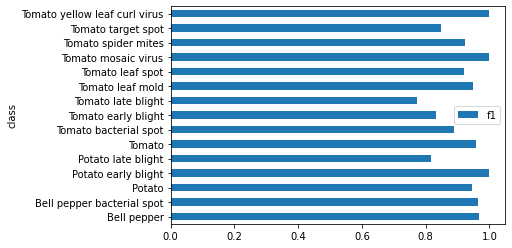

<AxesSubplot:ylabel='class'>

In [0]:
# Gather the F1 scores for each class and plot
f1_df = pd.DataFrame.from_records(
    [(c["class_name"], c["f1"]) for c in confusion_chart.class_metrics],
    columns=["class", "f1"],
)
f1_df.plot("class", "f1", kind="barh")

In [0]:
# Shows the activation maps for the top model
import io

import PIL.Image
from datarobot.models.visualai import ImageActivationMap

column_name = "b64image"
max_activation_maps = 5

for activation_map in ImageActivationMap.list(project.id, top_model.id, column_name)[
    :max_activation_maps
]:
    bio = io.BytesIO(activation_map.overlay_image.image_bytes)
    img = PIL.Image.open(bio)
    img.show()

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F08BE0AE100>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F08BE0AF640>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F08BE0AE100>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F08BE0AF4F0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7F08BE0AE0A0>

## Get predictions from the top model

Now that you are confident that the model does a good job, you can get predictions for some new images.

In [0]:
# You could now replicate the workflow in Section 3 with new images
# Here, reuse a small sample of the dataset (for demo purposes)
predict_dataset_catalog = dr.Dataset.create_from_in_memory_data(
    encoded_df_pandas.head(10)
)
predict_dataset = project.upload_dataset_from_catalog(
    dataset_id=predict_dataset_catalog.id
)
pred_job = top_model.request_predictions(predict_dataset.id)
preds = pred_job.get_result_when_complete()

In [0]:
# To inspect the predictions
preds.head()

Out[22]:

row_id 
 prediction 
 class_Bell pepper 
 class_Bell pepper bacterial spot 
 class_Potato 
 class_Potato early blight 
 class_Potato late blight 
 class_Tomato 
 class_Tomato bacterial spot 
 class_Tomato early blight 
 class_Tomato late blight 
 class_Tomato leaf mold 
 class_Tomato leaf spot 
 class_Tomato mosaic virus 
 class_Tomato spider mites 
 class_Tomato target spot 
 class_Tomato yellow leaf curl virus 
 
 
 
 
 0 
 0 
 Tomato 
 0.000023 
 2.475452e-07 
 8.330141e-06 
 7.066511e-06 
 0.000011 
 0.999812 
 0.000072 
 0.000006 
 1.282043e-05 
 5.510431e-06 
 2.171373e-06 
 9.058583e-07 
 2.852351e-05 
 0.000008 
 0.000003 
 
 
 1 
 1 
 Tomato 
 0.000003 
 2.782336e-07 
 9.963485e-08 
 3.284840e-07 
 0.000001 
 0.999975 
 0.000002 
 0.000010 
 3.968032e-07 
 7.088196e-08 
 1.726465e-07 
 6.410718e-07 
 7.789432e-07 
 0.000002 
 0.000004 
 
 
 2 
 2 
 Tomato 
 0.000068 
 4.101236e-05 
 2.977554e-04 
 2.422185e-04 
 0.000513 
 0.996666 
 0.000282 
 0.000153 
 3.358621e-04 
 1.942641e-05 
 2.432400e-04 
 6.814802e-05 
 5.273323e-05 
 0.000776 
 0.000241 
 
 
 3 
 3 
 Tomato 
 0.000004 
 1.766848e-06 
 4.562257e-05 
 4.728195e-06 
 0.000003 
 0.999841 
 0.000057 
 0.000007 
 9.697777e-06 
 3.337080e-07 
 1.679862e-06 
 5.726706e-06 
 8.786666e-06 
 0.000005 
 0.000005 
 
 
 4 
 4 
 Tomato 
 0.000021 
 4.743670e-06 
 5.791437e-05 
 1.601922e-05 
 0.000004 
 0.999514 
 0.000013 
 0.000042 
 7.418463e-06 
 1.579193e-04 
 2.595470e-06 
 7.625805e-06 
 1.064376e-04 
 0.000008 
 0.000038